Epoch 0, Loss: 1.9868e+00
Epoch 1000, Loss: 2.9371e-04
Epoch 2000, Loss: 1.3176e-04
Epoch 3000, Loss: 3.9474e-05
Epoch 4000, Loss: 1.0520e-04
Epoch 5000, Loss: 1.6795e-04
Epoch 6000, Loss: 1.8419e-04
Epoch 7000, Loss: 9.5465e-05
Epoch 8000, Loss: 6.5751e-06
Epoch 9000, Loss: 2.1574e-04


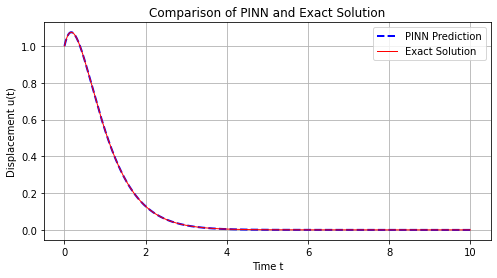

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the PINN network structure
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 20),   # Input layer: 1 neuron (x)
            nn.Tanh(),          # Activation function
            nn.Linear(20, 20),  # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 20),  # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 1)    # Output layer: 1 neuron (y)
        )
    
    def forward(self, x):
        return self.layers(x)

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 10000     # Number of training epochs
num_points = 1000  # Number of sampled points per training step

# Training loop
for epoch in range(epochs):
    # Randomly sample internal points (domain points)
    x_internal = torch.rand(num_points, 1) * 10.0
    x_internal.requires_grad = True
    
    # Compute differential equation residual
    y_pred = model(x_internal)
    dy_dx = torch.autograd.grad(y_pred, x_internal, 
                               grad_outputs=torch.ones_like(y_pred),
                               create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_internal,
                                 grad_outputs=torch.ones_like(dy_dx),
                                 create_graph=True)[0]
    residual = d2y_dx2 + 4*dy_dx + 4*y_pred
    equation_loss = torch.mean(residual**2)  # Equation loss
    
    # Compute initial condition loss
    x0 = torch.tensor([[0.0]], requires_grad=True)
    y0_pred = model(x0)
    dy0_pred = torch.autograd.grad(y0_pred, x0, create_graph=True)[0]
    
    # Loss for y(0)=1 and y'(0)=1
    initial_loss = (y0_pred - 1.0)**2 + (dy0_pred - 1.0)**2
    
    # Total loss
    total_loss = equation_loss + initial_loss
    
    # Backpropagation and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.4e}')

# Generate test data
x_test = torch.linspace(0, 10, 1000).reshape(-1, 1)
y_pred = model(x_test).detach().numpy()

# Compute analytical solution
x_analytical = x_test.numpy().flatten()
y_exact = (1 + 3*x_analytical) * np.exp(-2*x_analytical)

# Plot results
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
plt.figure(figsize=(8, 4))
plt.plot(x_test, y_pred, 'b--', linewidth=2, label='PINN Prediction')
plt.plot(x_test, y_exact, 'r-', linewidth=1, label='Exact Solution')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.legend()
plt.title('Comparison of PINN and Exact Solution')
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9999998682728625, mae_pinn: 8.655112469568849e-05, rmse_pinn: 9.961953765014187e-05, inf_norm_pinn: 0.0001888573169708252


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})


data_to_save.to_csv('pinn_09.csv', index=False)
print(" pinn_09.csv")

数据已保存至 pinn_09.csv
